# Algorithm1


In [ ]:
import numpy as np
import math
import matplotlib
from matplotlib import pyplot as plt
from matplotlib import rc
from numpy import asarray
from numpy import savetxt
from numpy.lib.arraypad import pad

## Handling Parameters



N is the number of machines (integer) - Machines' numbers range between 0 to N-1.
We exclude the attacker from the machines.

N_and_or_machine (AndOr), is a binary numpy array. Column "i" is equal "1", if and only if "i"-th machine is an AND-Machine.

weighted_BAG is an NxN numpy array. Filled with Rho_{ij}s.
boolean_BAG is an NxN numpy array. Showing the directed connectivity between nodes.

There are some leafs wich are only compromised directly by the attacker itself. So we have Rho_{l}s not in the BAG we mentioned, but in another
Nx1 numpy array: leaf_rhos

When we have a directed edge from machine i to j (Showing that j is exploitable via i), we put the corresponding Rho_{ij} at i-th row, j-th column of the matrix.

"O" is the set of observable machines. (given as a numpy array)
"m" is the number of observable machines, equal to "o" 's size.

"q" is the probability of not ditecting (missing) a compromised machine during an observation.

"A" is a matrix filled with the boolean representation of all states. (from $0$ to $2^N-1$).

**Assumptions:**

* It is different that you have a Rho_ij = 0 or there is no connection from "i" to "j". This is the reason we defined boolean_BAG.
* Here we assume that a "zero" in boolean_BAG, means there are no connections from "i" to "j".
* We also assume that there is at most one directed-edge from any "i" to any "j". (Or we have to reconsider our BAG structure.)

In [ ]:
# Global variables. (Edit: use them localy)
global N, AndOr, weighted_BAG, boolean_BAG, leaf_rhos, m, O, q, raw_Als, A
def set_parameters(N_and_or_machine, weighted_BAGi, leaf_rhosi, qi, boolean_BAGi=None , Oi=None):
    global N, AndOr, weighted_BAG, boolean_BAG, leaf_rhos, m, O, q, A
    N = len(N_and_or_machine)
    AndOr = N_and_or_machine
    weighted_BAG = weighted_BAGi
    # Observer items
    if Oi is not None:
        m = len(Oi)
        O = Oi
    # Boolean BAG
    if boolean_BAGi is None:
        boolean_BAG = np.copy(weighted_BAG)
        boolean_BAG[boolean_BAG > 0] = 1
    else:
        boolean_BAG = boolean_BAGi
    leaf_rhos = leaf_rhosi
    # Missing rate
    q = qi
    A = pre_process_A(N)
    return

## AL Generating

This process helps us with the calculation of the update_vector's elements.
For AND-Machines it can be pre-processed. For OR-Machines, needs to be calculated while previous state is given.

In [ ]:
def pre_process_Al():
    global weighted_BAG, AndOr, raw_Als
    raw_Als = np.zeros(N)
    for l in range(N):

        #if L is AND-Machine:
        if AndOr[l]:
            ### debug
            raw_Als[l] = np.prod(weighted_BAG[np.nonzero(weighted_BAG[:,l]),l])

        #if L is OR-Machine:
        #else:
            ### debug
            ### OR machines are not good with pre-processing!
            #raw_Als[l] = 1 - np.prod(1 - weighted_BAG[np.nonzero(weighted_BAG[:,l]),l])
    return raw_Als

# We have to calculate this for every X_prev. On the other hand, pre_processed_Al is independant of states.
def set_Als(raw_Als, X_prev):
    Als = np.zeros(N)
    for l in range(N):

        #if L is AND-Machine:
        if AndOr[l]:
            ### debug
            # Als[l] = raw_Als * np.all(X_prev & (boolean_BAG[:,l] == True))
            weighted_BAG_col = weighted_BAG[:, l]
            Als[l] = np.prod((weighted_BAG_col[boolean_BAG[:,l] == True]) * (X_prev[boolean_BAG[:,l] == True]))


        #if L is OR-Machine:
        else:
            ### debug
            # print(weighted_BAG[:, l] * (boolean_BAG[:,l] == False))
            # print((X_prev *(boolean_BAG[:,l] == True)))
            # Als[l] = 1 - np.prod(1 - (weighted_BAG[:, l] * (boolean_BAG[:,l] == False)) * (X_prev *(boolean_BAG[:,l] == True)))
            weighted_BAG_col = weighted_BAG[:, l]
            Als[l] = 1 - np.prod(1 - ( weighted_BAG_col[boolean_BAG[:,l] == True]) * (X_prev[boolean_BAG[:,l] == True]))

    return Als


## Boolean Array - Integer

In [ ]:
def int_to_N_boolean_digits_npArray(pre, N, curr= None):

    if curr is None:
        t = bin(pre)
        t = t[2:] # bin function output's format has a "0b" at the beginning. We omit it here.
        # res_pre = np.zeros(N).astype(np.int32)
        res_pre = np.full(N, False)

        for i in range(0, N):
            if i < N - len(t):
                res_pre[i] = 0
            else:
                res_pre[i] = int(t[i - N + len(t)]) # Since t elements are characters, t[i] is always true. It has to be converted to int then bool.
        return res_pre

    else:
        t = bin(pre)
        t = t[2:] # bin function output's format has a "0b" at the beginning. We omit it here.
        s = bin(curr)
        s = s[2:] # bin function output's format has a "0b" at the beginning. We omit it here.
        res_pre = np.full(N, False)
        res_curr = np.full(N, False)
        for i in range(0, N):
            if i < N - len(t):
                res_pre[i] = 0
            else:
                res_pre[i] = int(t[i - N + len(t)]) # Since t elements are characters, t[i] is always true. It has to be converted to int then bool.
            if i < N - len(s):
                res_curr[i] = 0
            else:
                res_curr[i] = int(s[i - N + len(s)]) # Since t elements are characters, t[i] is always true. It has to be converted to int then bool.

        return res_pre, res_curr

        #print(y[-i])#

def pre_process_A(N):
  A = np.zeros([N , 2**N])
  for i in range(0, 2**N):
      binary = int_to_N_boolean_digits_npArray(i, N, curr= None)
      A[:, i] = binary
  return A

print(pre_process_A(5))

[[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 1. 1. 1. 1. 1. 1. 1.
  1. 1. 1. 1. 1. 1. 1. 1.]
 [0. 0. 0. 0. 0. 0. 0. 0. 1. 1. 1. 1. 1. 1. 1. 1. 0. 0. 0. 0. 0. 0. 0. 0.
  1. 1. 1. 1. 1. 1. 1. 1.]
 [0. 0. 0. 0. 1. 1. 1. 1. 0. 0. 0. 0. 1. 1. 1. 1. 0. 0. 0. 0. 1. 1. 1. 1.
  0. 0. 0. 0. 1. 1. 1. 1.]
 [0. 0. 1. 1. 0. 0. 1. 1. 0. 0. 1. 1. 0. 0. 1. 1. 0. 0. 1. 1. 0. 0. 1. 1.
  0. 0. 1. 1. 0. 0. 1. 1.]
 [0. 1. 0. 1. 0. 1. 0. 1. 0. 1. 0. 1. 0. 1. 0. 1. 0. 1. 0. 1. 0. 1. 0. 1.
  0. 1. 0. 1. 0. 1. 0. 1.]]


## Generating transition matrix

In [ ]:
# Calculates the whole transition matrix when X_curr || X_prev == None
# Calculates the X_curr-th row X_prev-th column of transition matrix when X_curr,X_prev != -1
# What is the format of X_curr, X_prev? One dimensional numpy arrays of size N.
# ****************** Somewhere you should gain/call raw_Als. Outside this method.

# def gain_transition_matrix(X_curr=None, X_prev=None):
#     global raw_Als
#     if X_curr is None or X_prev is None:
#         # Set arrays
#         transition_matrix = np.zeros((2**N, 2**N))
#         res = np.zeros(N)
#         # Calculate each element
#         for pre in range(2**N):
#             for curr in range(2**N):
#                 X_prev = A[:, pre]
#                 X_curr = A[:, curr]
#                 # Sum of columns should be 1: Pre is Col, Curr is Row.
#                 transition_matrix[curr][pre] = gain_transition_matrix(X_curr, X_prev)
#         return transition_matrix

#     # Transition Matrix at row [X_prev], col [X_curr]:
#     # Returns a real number. Probability of being in current state, given our previous state.

#     else:
#         res = np.zeros(N)
#         Als = set_Als(raw_Als, X_prev)
#         prob_successfuly_compromised = Als * (1-leaf_rhos) + leaf_rhos
#         # print("prob:" + str(prob_successfuly_compromised))
#         # print("THis is Als for " + str(X_prev))
#         # print(Als)
#         # pre = 0, curr = 0
#         res[(X_prev==0) & (X_curr == 0)] = 1 - prob_successfuly_compromised[(X_prev==0) & (X_curr == 0)]
#         # pre = 0, curr = 1
#         res[(X_prev==0) & (X_curr == 1)] = prob_successfuly_compromised[(X_prev==0) & (X_curr == 1)]
#         # pre = 1, curr = 0
#         #res[(X_prev==1) & (X_curr == 0)] = 0
#         # pre = 1, curr = 1
#         res[(X_prev==1) & (X_curr == 1)] = 1
#         probability_of_state_transition = np.prod(res)

#         return probability_of_state_transition


**New Code Examine for Transition Matrix:**

In [ ]:
# Calculates the whole transition matrix when X_curr || X_prev == None
# Calculates the X_curr-th row X_prev-th column of transition matrix when X_curr,X_prev != -1
# What is the format of X_curr, X_prev? One dimensional numpy arrays of size N.
# ****************** Somewhere you should gain/call raw_Als. Outside this method.

def gain_transition_matrix(X_curr=None, X_prev=None):
    global raw_Als
      # Set arrays
    transition_matrix = np.zeros((2**N, 2**N))
    res = np.zeros(N)
    # Calculate each element
    for pre in range(2**N):
        for curr in range(2**N):
            X_prev = A[:, pre]
            X_curr = A[:, curr]
            # Sum of columns should be 1: Pre is Col, Curr is Row.
            res = np.zeros(N)
            Als = set_Als(raw_Als, X_prev)
            prob_successfuly_compromised = Als * (1-leaf_rhos) + leaf_rhos
            # print("prob:" + str(prob_successfuly_compromised))
            # print("THis is Als for " + str(X_prev))
            # print(Als)
            # pre = 0, curr = 0
            res[(X_prev==0) & (X_curr == 0)] = 1 - prob_successfuly_compromised[(X_prev==0) & (X_curr == 0)]
            # pre = 0, curr = 1
            res[(X_prev==0) & (X_curr == 1)] = prob_successfuly_compromised[(X_prev==0) & (X_curr == 1)]
            # pre = 1, curr = 0
            #res[(X_prev==1) & (X_curr == 0)] = 0
            # pre = 1, curr = 1
            res[(X_prev==1) & (X_curr == 1)] = 1
            probability_of_state_transition = np.prod(res)
            transition_matrix[curr][pre] = probability_of_state_transition

    return transition_matrix

  # Transition Matrix at row [X_prev], col [X_curr]:
  # Returns a real number. Probability of being in current state, given our previous state.

## Generating Update Vector

In [ ]:
from numpy.lib.function_base import append
def gain_update_vector(Y_curr, a_pre=None):
    if a_pre is None:
        a_pre = np.arange(0, N, 1, dtype=np.int32)
    Y_curr = np.reshape(Y_curr, (N, 1))
    Y_curr_all_col = np.matmul(Y_curr, np.full((1, 2**N), 1))
    # print(Y_curr_all_col)
    partially_observed_res = np.abs((-1+q)*A[a_pre,:] - Y_curr_all_col[a_pre] + 1)
    update_vector = np.prod(partially_observed_res, axis=0)
    # print("update vector is: ")
    # print(update_vector)
    return update_vector

In [ ]:
# Y_curr = np.full((N, 1),1)
# Y_curr_all_col = np.matmul(Y_curr, np.full((1, 2**N), 1))

# partially_observed_res=np.abs((-1+q)*A[[],:] - Y_curr_all_col[[]] + 1)
# update_vector = np.prod(partially_observed_res, axis=0)

# print(update_vector)


In [ ]:
x = np.array([[12, 23, 43, 45], [1, 2, 3, 4]])
print(np.prod(x, axis=0))
print(np.shape(x))

[ 12  46 129 180]
(2, 4)


# Test Cases

### Given Example 10 Machines


In [ ]:
smp1_wb = np.array([[0, 0, 0, 0.57, 0, 0, 0, 0, 0, 0],
                 [ 0, 0, 0, 0.57, 0, 0, 0, 0, 0, 0],
                 [ 0, 0, 0, 0.57, 0.4329, 0, 0, 0, 0, 0],
                 [ 0, 0, 0, 0, 0, 0.8054, 0.7722, 0, 0, 0],
                 [ 0, 0, 0, 0, 0, 0.8054, 0.7722, 0.3549, 0, 0],
                 [ 0, 0, 0, 0, 0, 0, 0, 0.3549, 0.34, 0.3811],
                 [ 0, 0, 0, 0, 0, 0, 0, 0.3549, 0, 0.3811],
                 [ 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
                 [ 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
                 [ 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
                ], dtype= np.float64)
smp1_lr = np.array([ 0.69, 0.62, 0.53, 0, 0, 0, 0, 0, 0, 0])
# What are AND/OR s?
smp1_andor = np.array([0, 0, 0, 0, 1, 0, 0, 1, 1, 1], dtype= np.bool_)
smp1_q = 0.2
smp1_o = np.array([0, 1, 2, 3, 4, 5, 6, 7, 8, 9], dtype= np.int32)
# print(smp1_wb)
# print()
# print(smp1_andor)

In [ ]:
print(smp1_wb)

[[0.     0.     0.     0.57   0.     0.     0.     0.     0.     0.    ]
 [0.     0.     0.     0.57   0.     0.     0.     0.     0.     0.    ]
 [0.     0.     0.     0.57   0.4329 0.     0.     0.     0.     0.    ]
 [0.     0.     0.     0.     0.     0.8054 0.7722 0.     0.     0.    ]
 [0.     0.     0.     0.     0.     0.8054 0.7722 0.3549 0.     0.    ]
 [0.     0.     0.     0.     0.     0.     0.     0.3549 0.34   0.3811]
 [0.     0.     0.     0.     0.     0.     0.     0.3549 0.     0.3811]
 [0.     0.     0.     0.     0.     0.     0.     0.     0.     0.    ]
 [0.     0.     0.     0.     0.     0.     0.     0.     0.     0.    ]
 [0.     0.     0.     0.     0.     0.     0.     0.     0.     0.    ]]


In [ ]:
set_parameters(N_and_or_machine= smp1_andor, weighted_BAGi= smp1_wb, leaf_rhosi=smp1_lr, boolean_BAGi=None , Oi=smp1_o, qi= smp1_q)
print(AndOr)
print(weighted_BAG)
print(boolean_BAG)
print(q)
print(N)
pre_process_Al()

[False False False False  True False False  True  True  True]
[[0.     0.     0.     0.57   0.     0.     0.     0.     0.     0.    ]
 [0.     0.     0.     0.57   0.     0.     0.     0.     0.     0.    ]
 [0.     0.     0.     0.57   0.4329 0.     0.     0.     0.     0.    ]
 [0.     0.     0.     0.     0.     0.8054 0.7722 0.     0.     0.    ]
 [0.     0.     0.     0.     0.     0.8054 0.7722 0.3549 0.     0.    ]
 [0.     0.     0.     0.     0.     0.     0.     0.3549 0.34   0.3811]
 [0.     0.     0.     0.     0.     0.     0.     0.3549 0.     0.3811]
 [0.     0.     0.     0.     0.     0.     0.     0.     0.     0.    ]
 [0.     0.     0.     0.     0.     0.     0.     0.     0.     0.    ]
 [0.     0.     0.     0.     0.     0.     0.     0.     0.     0.    ]]
[[0. 0. 0. 1. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 1. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 1. 1. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 1. 1. 0. 0. 0.]
 [0. 0. 0. 0. 0. 1. 1. 1. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 1. 1. 1.]
 [0. 0. 0

array([0.        , 0.        , 0.        , 0.        , 0.4329    ,
       0.        , 0.        , 0.04470108, 0.34      , 0.14523721])

# Main

## Transition Matrix

In [ ]:
try:
  transition_matrix = np.load('transition_matrix.npy')
  print("transition matrix has been loaded.")
except:
  transition_matrix = np.copy(gain_transition_matrix())
  np.save('transition_matrix.npy', transition_matrix)
  print("transition matrix has been created (not loaded).")
  pass
  "print(transition_matrix)"


transition matrix has been created (not loaded).


In [ ]:
print(np.sum(transition_matrix[:,0]))

1.0


In [ ]:
print(transition_matrix[2**N-1:0]==(0.79*0.63*math.pow(0.1, 5)))
print(0.79*0.63*math.pow(0.1, 5))

[]
4.977000000000002e-06


## Create and Save Original Trajectory

In [ ]:
Pi_pre = np.full(2**N, 1/2**N)
print(Pi_pre)
# pre is initial state of machines.
pre = 0

[0.00097656 0.00097656 0.00097656 ... 0.00097656 0.00097656 0.00097656]


In [ ]:
T = 20
max_num = 100
q_list = [0, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1]
X_gen = np.zeros((max_num, T, N))
for num in range(0, max_num):
  pre = np.random.choice(np.arange(0,256))
  for t in range(0, T):
    X_curr = A[:, pre]
    X_gen[num,t,:] = np.copy(X_curr)
    curr = np.random.choice(2**N, p=transition_matrix[:, pre])
    pre = curr
for q in q_list:
  XandY_list = []
  for num in range(0, max_num):
    XandY = []
    for t in range(0, T):
      X_curr = X_gen[num,t,:]
      # If Xi == 0, we observe Yi == 0 with probability of 1.
      # If Xi == 1, we observe Yi == 1 with probability of 1-q.
      p = (1 - (1-q) * X_curr)
      Y_curr = np.zeros(N)
      for i in range(N):
        Y_curr[i] = np.random.choice([0, 1],  p=[p[i], 1-p[i]])
      XandY.append(np.array([X_curr, Y_curr]))
    XandY_list.append(XandY)
  np.save('XandY_list'+'q'+str(q)+'.npy', XandY_list)    # .npy extension is added if not given

### Load Trajectory

In [ ]:
# XandY_list = []
# for num in range(0, max_num):
#   XandY = np.load('XandY_'+ str(num) + '.npy')    # .npy extension is added if not given
#   # print(XandY)
#   XandY_list.append(XandY)
# XandY_list = np.load('XandY_list'+'q'+str(q)+'.npy')    # .npy extension is added if not given


In [ ]:
# i=5
# for XandY in XandY_list:
#   print(XandY[1][0])
#   print(XandY[1][1])
#   print('---')
#   i -= 1
#   if i == 0:
#     break

## Monitoring

In [ ]:
def initiate_monitoring(mode=None, threshold=None, O=None, fixed_par= 1):
  global m
  if O is not None:
    return O
  # if mode is None or mode=="all" or mode=="threshold":
  #   res = np.arange(N)
  #   return res
  if (mode== "ours") or (mode== "path") or (mode=="max_diff"):
    t = np.random.choice(np.arange(N), size=m, replace=False)
  elif mode=='alll':
    return np.arange(N)
  # if fixed:

In [ ]:
def bar(mat):
  matrix = np.copy(mat)
  matrix[matrix>=0.5] = 1
  matrix[matrix<0.5] = 0
  return matrix

In [ ]:
def update_monitor(O, A_Pi_pre= None, Pi_curr=None, mode=None, threshold=None):
  global m
  if mode==None or mode=="ours":
    # Preservs length
    # a = np.copy(A_Pi_pre)
    # b = 1 - np.copy(a)
    # a[a>b] = b[a>b]
    A_Pi_pre_bar = bar(A_Pi_pre)
    # print(A_Pi_pre_bar)
    # print("THIS IS A_PI_PRE INSIDE:")
    # print(A_Pi_pre)
    a = np.abs(A_Pi_pre - A_Pi_pre_bar)
    arg_sorted = np.argsort(a)
    # N-1 is last index. N-k is kth greatest.
    mth = a[arg_sorted[N-m]]
    # print(mth)
    mask = np.full(N, False)
    mask[a == mth] = True
    # print(mask)
    num_eq = np.sum(mask)
    # print(num_eq)
    mask2 = np.full(m-1, False)
    mask2[a[arg_sorted[N-m+1:]] == mth] = True
    # print(mask2)
    num_eq_aftr = np.sum(mask2)
    aa = N - m + num_eq_aftr - num_eq + 1
    bb = N - m + num_eq_aftr + 1
    eq_indices = arg_sorted[aa:bb]
    # print(eq_indices)
    r = np.random.choice(eq_indices, num_eq_aftr+1, replace=False)
    # print(r)
    O = np.zeros(m, dtype=np.int32)
    O[0:m-num_eq_aftr-1] = arg_sorted[N-m+1+num_eq_aftr:]
    O[m-num_eq_aftr-1:] = r
    # print("a is:")
    # print(a)
    # print("O is")
    # print(O)
    return O

  elif mode=="path":
    W = np.arange(Pi_curr.size).reshape(Pi_curr.shape)
    K = W[Pi_curr == np.max(Pi_curr)]
    s_pre = np.random.choice(K, size=1)
    s_pre_arr = A[:,s_pre]
    mon = np.zeros(2) - 1
    repeat = 0
    while (np.min(mon) == -1) and repeat<10:
      s_nxt_prob = transition_matrix[:,s_pre]
      # print(s_nxt_prob)
      W = np.arange(s_nxt_prob.size).reshape(s_nxt_prob.shape)
      K = W[s_nxt_prob == np.max(s_nxt_prob)]
      s_nxt = np.random.choice(K, size=1)
      s_nxt_arr = A[:,s_nxt]
      comp = s_nxt_arr - s_pre_arr
      s_pre = np.copy(s_nxt)
      s_pre_arr = np.copy(s_nxt_arr)
      W = np.arange(comp.size).reshape(comp.shape)
      K = W[comp == 1]
      if K.size == 1:
        mon[np.argmin(mon)] = K[0]
      elif K.size>1:
        mon = np.random.choice(K, size=2)
      repeat += 1
    if (mon[0] == -1) and (mon[1] == -1):
      return np.random.choice(np.arange(10), size=2, replace=False).astype(int)
    elif (mon[0] == -1) or (mon[1] == -1):
      return np.random.choice(np.arange(10), size=1)
    return mon.astype(int)

  elif mode=="max_diff":
    diff = A_Pi_pre - np.matmul(A, Pi_curr)
    W = np.arange(diff.size).reshape(diff.shape)
    K = W[diff == np.max(diff)]
    mon = np.zeros(2) - 1
    if K.size > 1:
      mon = np.random.choice(K, size=2)
    else:
      mon[0] = W[0]
      W = np.arange(diff.size).reshape(diff.shape)
      K = W[diff == np.partition(diff.flatten(), -2)[-2]]
      mon[1] = np.random.choice(K, size=1)
    return mon.astype(int)

  elif mode=="alll":
    return np.arange(10)



In [ ]:
O = initiate_monitoring(mode="alll")
print(O)

[0 1 2 3 4 5 6 7 8 9]


## Evaluations

In [ ]:
def evaluate(X_curr, X_est, error_list, tot_error_list, acc_list, i , T):
      # Initialize
      acc = 0
      hamming = 0
      abs = 0
      if tot_error_list == []:
        tot_error_list = np.zeros(T)
      if acc_list == []:
        acc_list = np.zeros(T)
      # Calculation
      if np.all(X_curr == X_est):
        acc = 1
      hamming = np.sum(np.abs(X_curr - X_est))
      err = np.abs((X_curr - X_est)**2)
      # Add to list
      error_list.append(err)
      tot_error_list[i] = hamming
      acc_list[i] = acc
      return error_list, tot_error_list, acc_list


## Main Loop

In [ ]:
# "T" is the number of iterations (number of state transitions).
# T = 5
global  ours, path, max_diff, alll
ours, path, max_diff, alll = [], [], [], []
packed_for_m = []

# m_list = np.arange(N) + 1
m_list = [2]
for qq in q_list:
  q = qq
  packed_for_m = []
  for m in m_list:
    if (q != 0.2) and (m != 2):
      continue
    modes = ['ours', 'path', 'max_diff', 'alll']
    num = -1
    XandY_list = np.load('XandY_list'+'q'+str(q)+'.npy')
    for mode in modes:
      num = -1
      all_est_list, all_err_list, all_tot_err_list, all_acc_list, all_mon_list, all_MSE_list, all_MSE_each_list = [], [], [], [], [], [], []
      for XandY in XandY_list:
        num += 1
        X_est_list = []
        error_list, tot_error_list, acc_list, monitor_list, MSE_list, MSE_each_list = [], [], [], [], [], []
        Pi_pre = np.full(2**N, 1/2**N)
        O = initiate_monitoring(mode=mode)
        # O = update_monitor(O, A_Pi_pre=np.matmul(A, Pi_pre), Pi_curr=Pi_pre, mode=mode)
        for t in range(0, T):
            # Use trajectory
            X_curr = XandY[t][0]
            Y_curr = XandY[t][1]
            # print(O)
            nominator = gain_update_vector(Y_curr=Y_curr, a_pre= O) * Pi_pre
            Pi_curr = nominator / np.sum(nominator)
            X_est = np.full(N, False)
            A_Pi_curr = np.matmul(A, Pi_curr)
            X_est[A_Pi_curr > 0.5] = True
            MSE_each = np.abs(A_Pi_curr - X_est)
            MSE = np.sum(MSE_each)
            X_est_list.append(X_est)
            MSE_list.append(MSE)
            MSE_each_list.append(MSE_each)
            error_list, tot_error_list, acc_list = evaluate(X_curr, X_est, error_list, tot_error_list, acc_list, t , T)
            Pi_pre = np.matmul(transition_matrix, np.copy(Pi_curr))
            A_Pi_pre = np.matmul(A, Pi_pre)
            monitor_list.append(O)
            O = update_monitor(O, A_Pi_pre=A_Pi_pre, Pi_curr=Pi_curr, mode=mode)

        all_est_list.append(X_est_list)
        all_err_list.append(error_list)
        all_tot_err_list.append(tot_error_list)
        all_acc_list.append(acc_list)
        all_mon_list.append(monitor_list)
        all_MSE_list.append(MSE_list)
        all_MSE_each_list.append(MSE_each_list)
      if mode == 'path':
        path = (all_est_list, all_err_list, all_tot_err_list, all_acc_list, all_mon_list, all_MSE_list, all_MSE_each_list)
      elif mode == 'ours':
        ours = (all_est_list, all_err_list, all_tot_err_list, all_acc_list, all_mon_list, all_MSE_list, all_MSE_each_list)
      elif mode == 'max_diff':
        max_diff = (all_est_list, all_err_list, all_tot_err_list, all_acc_list, all_mon_list, all_MSE_list, all_MSE_each_list)
      elif mode == 'alll':
        alll = (all_est_list, all_err_list, all_tot_err_list, all_acc_list, all_mon_list, all_MSE_list, all_MSE_each_list)

    packed_for_m.append((ours, path, max_diff, alll))
    np.save('packed_for_m'+str(m)+'q'+str(q)+'.npy', packed_for_m)

        # print("Accuracy is: " + str(np.sum(acc_list)/T))
        # print("Mean tot error is: " + str(np.sum(tot_error_list)/T))
        # print("Mean error is: " + str(np.sum(error_list)/T))




<ipython-input-24-0bd5e25768a9>:6: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  if tot_error_list == []:
<ipython-input-24-0bd5e25768a9>:8: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  if acc_list == []:
/usr/local/lib/python3.9/dist-packages/numpy/lib/npyio.py:518: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  arr = np.asanyarray(arr)


# Diagrams

## functions

In [ ]:
global mode_labels, mode_colors
mode_labels = ['Proposed Fixed Resource Monitoring', 'Tree-Based Monitoring' , 'Probabilistic Monitoring', 'All Nodes Monitoring (Baseline)']
mode_colors = ['#0000FF', '#7D451A', '#666666', '#000000']
modes = ['ours', 'path', 'max_diff', 'alll']
T = 20; m = 2; N = 10; max_num = 100

In [ ]:
def mode_handler(mode, ind=None):
  global ours, path, max_diff, alll, mode_labels, mode_colors
  handler = None
  if ind is not None:
    if mode == 'path':
      handler = path[ind]
    elif mode == 'ours':
      handler = ours[ind]
    elif mode == 'max_diff':
      handler = max_diff[ind]
    elif mode == 'alll':
      handler = alll[ind]

  if mode == 'path':
    label = mode_labels[1]
    color = mode_colors[1]
  elif mode == 'ours':
    label = mode_labels[0]
    color = mode_colors[0]
  elif mode == 'max_diff':
    label = mode_labels[2]
    color = mode_colors[2]
  elif mode == 'alll':
    label = mode_labels[3]
    color = mode_colors[3]
  return handler, label, color

In [ ]:
packed_for_m = np.load('packed_for_m'+str(m)+'q'+str(0.2)+'.npy',
                       allow_pickle=True)

### Avg error + Avg Accuracy


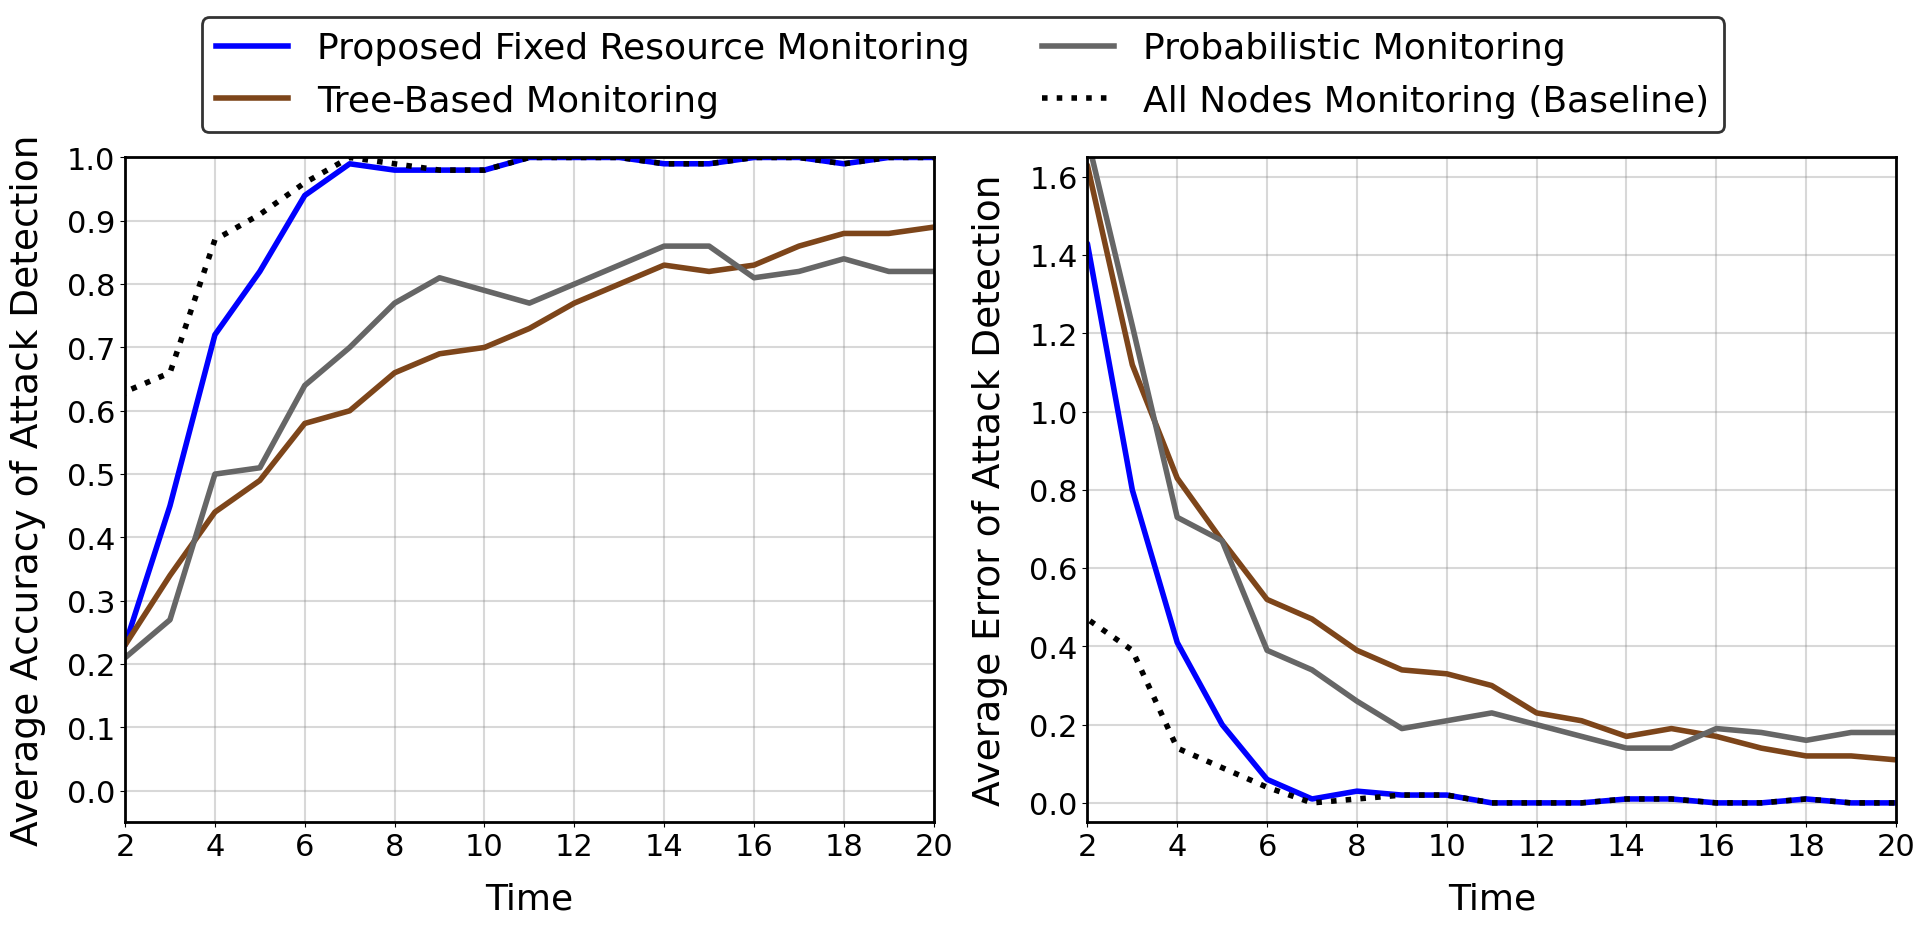

In [ ]:
plt.rcdefaults()
fig, axis = plt.subplots(nrows=1, ncols=2, sharex=False, sharey=False)
fontsize = 26
for pack in packed_for_m:
  for mode in modes:
    (ours, path, max_diff, alll) = pack
    all_tot_err_list, mode_label, mode_color= mode_handler(mode, 2)
    all_acc_list, mode_label, mode_color = mode_handler(mode, 3)
    mean_tot_err_list = np.zeros(T)
    mean_acc_list = np.zeros(T)
    for num in range(0, max_num):
      mean_tot_err_list += all_tot_err_list[num].astype(float)
      mean_acc_list += all_acc_list[num].astype(float)
    mean_tot_err_list/= max_num
    mean_acc_list/= max_num
    X = np.arange(0, T)

    linestyle = "solid"
    if mode == "alll":
      linestyle = "dotted"
    axis[1].plot(X, mean_tot_err_list, linewidth=4, label=mode_label, color=mode_color, linestyle=linestyle)
    axis[0].plot(X, mean_acc_list, linewidth=4, label=mode_label, color=mode_color, linestyle=linestyle)

  yticks = np.arange(11)/10
  X_t = np.arange(0, T/2)*2
  X_labels = [2, 4, 6, 8, 10, 12, 14, 16, 18, 20]
  axis[0].set_xticks(ticks=X_t+1, labels=X_labels, fontsize=fontsize-4)
  axis[0].set_ylabel(r'Average Accuracy of Attack Detection', fontsize=fontsize+1, labelpad=15)
  axis[0].set_xlabel(r'Time', fontsize=fontsize, labelpad=15)
  axis[0].grid(color='gray', linestyle='-', linewidth=1.5, alpha=0.3)
  # axis[1].set_legend(loc='best',prop={'size': fontsize-2} )
  axis[0].set_xlim([1,T-1])
  axis[0].set_ylim([-0.05,1])
  axis[0].set_yticks(ticks=yticks, labels=yticks, fontsize=fontsize-4)

  axis[1].set_xlim([1,T-1])
  axis[1].set_ylim([-0.05, 1.65])
  axis[1].set_xticks(ticks=X_t+1, labels=X_labels, fontsize=fontsize-4)
  axis[1].set_ylabel(r'Average Error of Attack Detection', fontsize=fontsize+1, labelpad=15)
  axis[1].set_xlabel(r'Time', fontsize=fontsize, labelpad=15)
  axis[1].grid(color='gray', linestyle='-', linewidth=1.5, alpha=0.3)
  Y_labels = [0.0, 0.2, 0.4, 0.6, 0.8, 1.0, 1.2, 1.4, 1.6]
  axis[1].set_yticks(np.arange(0,1.8,0.2), labels=Y_labels, fontsize=fontsize-4)


[x.set_linewidth(2) for x in axis[0].spines.values()]
[x.set_linewidth(2) for x in axis[1].spines.values()]
# fig.text(0.5, 0.04, 'Number of Reimaged Nodes per Step', ha='center', fontsize=fontsize+1)
fig.set_size_inches(23, 9.5)
handles, labels = axis[0].get_legend_handles_labels()
leg = fig.legend(handles, labels, loc='upper center', prop={'size': fontsize}, ncol= 2)
leg.get_frame().set_linewidth(2)
leg.get_frame().set_edgecolor("black")
# fig.text(0.09, 0.5, 'Average Compromise Rate', va='center', rotation='vertical', fontsize=fontsize+1)
plt.subplots_adjust(left=0.13, bottom=0.125, right=0.9, top=0.825
                    , wspace=0.19, hspace=0.05)
plt.show()
fig.savefig('Figure 8.svg', format='svg', dpi=1200)
fig.savefig('Figure 8.jpg', format='jpg', dpi=1200)
fig.savefig('Figure 8.eps', format='eps', dpi=1200)